<a href="https://colab.research.google.com/github/woodRock/fishy-business/blob/main/code/identification/part/embedded-gp/run_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-tree Genetic Program

In [20]:
# Freeze the seed for reproduceability.
run = 1 # @param {type: "integer"}

# The number of features in the dataset.
n_features = 1023

# Hyperparameters
beta = 1 # @param {type: "integer"}
population = n_features * beta
generations = 500 # @param {type: "integer"}
elitism = 0.1 # @param {type: "number"}
crossover_rate = 0.8 # @param {type: "number"}
mutation_rate = 0.2 # @param {type: "number"}

assert crossover_rate + mutation_rate == 1, "Crossover and mutation sums to 1 (to please the Gods!)"

In [21]:
!pip install deap
!apt install libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgraphviz-dev is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [22]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import scipy.io
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from google.colab import drive

from google.colab import drive
drive.mount('/content/drive')
data_path_gdrive = '/content/drive/MyDrive/AI/Data'
dataset = 'Part' #@param ["Fish", "Part"]

drive.mount('/content/drive')
os.listdir('/content/drive/My Drive')

path = ['drive', 'MyDrive', 'AI', 'fish', 'REIMS_data.xlsx']
path = os.path.join(*path)

# Load the dataset
print("[INFO] Reading the dataset.")
raw = pd.read_excel(path)

data = raw[~raw['m/z'].str.contains('HM')]
data = data[~data['m/z'].str.contains('QC')]
data = data[~data['m/z'].str.contains('HM')]
X = data.drop('m/z', axis=1) # X contains only the features.
y = data['m/z'].apply(lambda x:
                          0 if 'Fillet' in x
                    else  1 if 'Heads' in x
                    else (2 if 'Livers' in x
                    else (3 if 'Skins' in x
                    else (4 if 'Guts' in x
                    else (5 if 'Frames' in x
                    else None )))))  # For fish parts
xs = []
ys = []
for (x,y) in zip(X.to_numpy(),y):
    if y is not None and not np.isnan(y):
       xs.append(x)
       ys.append(y)
X = np.array(xs)
y = np.array(ys)

classes, class_counts = np.unique(y, axis=0, return_counts=True)
n_features = X.shape[1]
n_instances = X.shape[0]
n_classes = len(np.unique(y, axis=0))
class_ratios = np.array(class_counts) / n_instances

print(f"Class Counts: {class_counts}, Class Ratios: {class_ratios}")
print(f"Number of features: {n_features}\nNumber of instances: {n_instances}\nNumber of classes {n_classes}.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[INFO] Reading the dataset.
Class Counts: [6 6 3 6 6 3], Class Ratios: [0.2 0.2 0.1 0.2 0.2 0.1]
Number of features: 1023
Number of instances: 30
Number of classes 6.


In [23]:
import math
import copy
import random
import operator
from re import I
from operator import attrgetter
from functools import wraps, partial

import numpy as np

from deap import algorithms
from deap.algorithms import varAnd
from deap import base, creator, tools, gp
from deap.gp import PrimitiveTree, Primitive, Terminal

from sklearn.metrics import balanced_accuracy_score

pset = gp.PrimitiveSet("MAIN", n_features)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(operator.neg, 1)
# pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))

In [24]:
toolbox = base.Toolbox()

minimized = False
if minimized:
    weight = -1.0
else:
    weight = 1.0

weights = (weight,)

if minimized:
    creator.create("FitnessMin", base.Fitness, weights=weights)
    creator.create("Individual", list, fitness=creator.FitnessMin)
else:
    creator.create("FitnessMax", base.Fitness, weights=weights)
    creator.create("Individual", list, fitness=creator.FitnessMax)

def quick_evaluate(expr: PrimitiveTree, pset, data, prefix='ARG'):
    """ Quick evaluate offers a 500% speedup for the evluation of GP trees.

    The default implementation of gp.compile provided by the DEAP library is
    horrendously inefficient. (Zhang 2022) has shared his code which leads to a
    5x speedup in the compilation and evaluation of GP trees when compared to the
    standard library approach.

    For multi-tree GP, this speedup factor is invaluable! As each individual conists
    of m trees. For the fish dataset we have 4 classes, each with 3 constructed features,
    which corresponds to 4 classes x 3 features = 12 trees for each individual.
    12 trees x 500% speedup = 6,000% overall speedup, or 60 times faster.
    The 500% speedup is fundamental, for efficient evaluation of multi-tree GP.

    Args:
        expr (PrimitiveTree): The uncompiled (gp.PrimitiveTree) GP tree.
        pset: The primitive set.
        data: The dataset to evaluate the GP tree for.
        prefix: Prefix for variable arguments. Defaults to ARG.

    Returns:
        The (array-like) result of the GP tree evaluate on the dataset .
    """
    result = None
    stack = []
    for node in expr:
        stack.append((node, []))
        while len(stack[-1][1]) == stack[-1][0].arity:
            prim, args = stack.pop()
            if isinstance(prim, Primitive):
                result = pset.context[prim.name](*args)
            elif isinstance(prim, Terminal):
                if prefix in prim.name:
                    result = data[:, int(prim.name.replace(prefix, ''))]
                else:
                    result = prim.value
            else:
                raise Exception
            if len(stack) == 0:
                break # If stack is empty, all nodes should have been seen
            stack[-1][1].append(result)
    return result

def compileMultiTree(expr, pset):
    """Compile the expression represented by a list of trees.

    A variation of the gp.compileADF method, that handles Multi-tree GP.

    Args:
        expr: Expression to compile. It can either be a PrimitiveTree,
                 a string of Python code or any object that when
                 converted into string produced a valid Python code
                 expression.
        pset: Primitive Set

    Returns:
        A set of functions that correspond for each tree in the Multi-tree.
    """
    funcs = []
    gp_tree = None
    func = None

    for subexpr in expr:
        gp_tree = gp.PrimitiveTree(subexpr)
        # 5x speedup by manually parsing GP tree (Zhang 2022) https://mail.google.com/mail/u/0/#inbox/FMfcgzGqQmQthcqPCCNmstgLZlKGXvbc
        func = quick_evaluate(gp_tree, pset, X, prefix='ARG')
        funcs.append(func)

    # Hengzhe's method returns the features in the wrong rotation for multi-tree
    features = np.array(funcs).T
    return features

# MCIFC constructs 8 feautres for a (c=4) multi-class classification problem (Tran 2019).
# c - number of classes, r - construction ratio, m - total number of constructed features.
# m = r * c = 2 ratio * 4 classes = 8 features

r = 1
c = n_classes
m = r * c

toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.expr, n=m)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", compileMultiTree)

## Infinite speedup!?

For multi-tree GP, this speedup factor is invaluable! As each individual conists of m trees. For the fish dataset we have 4 classes, each with 3 constructed features, which corresponds to 4 classes x 3 features = 12 trees for each individual. 12 trees x 500% speedup = 6,000% overall speedup, or 60 times faster. The 500% speedup is fundamental, for efficient evaluation of multi-tree GP.

The evaluation below shows my calculations may still be wrong. And perhaps, it is even faster:

In [25]:
first = toolbox.population(n=1)[0]

subtree = first[0]
gp_tree = gp.PrimitiveTree(subtree)

%timeit gp.compile(gp_tree, pset)
%timeit quick_evaluate(gp_tree, pset, X)

1.74 ms ± 95.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
4.46 µs ± 164 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [26]:
from sklearn.svm import LinearSVC as svm
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.model_selection import cross_val_score
import numpy as np

def normalize(x):
    """
    Normalize a numpy array to interclass/intraclass distance sum to 1.

    Args:
        x: numpy array to be normalized.

    Returns:
        numpy array normalized to interclass/intraclass distance sum to 1.
    """
    x_norm = (x-np.min(x))/(np.max(x)-np.min(x))
    return x_norm

def is_same_class(a,b):
    """
    Return True if a and b are in the same class.

    Args:
        a: first point
        b: second point

    Returns:
        True if a and b are in the same class.
    """
    return a[1] == b[1]

def euclidian_distance(a,b):
    """
    Return the euclidian distance between two points.

    Args:
        a: first point
        b: second point

    Returns:
        Euclidian distance between a and b.
    """
    a,b = a[0], b[0]
    return np.linalg.norm(a-b)

def intraclass_distance(_X,_y):
    """
    Return the intra-class distance for a dataset.
    The average distance between all pairs of instances that are from the same class.

    Args:
        _X: numpy array of features.
        _y: numpy array of labels.

    Returns:
        Intra-class distance for a dataset.
    """
    data = list(zip(_X, _y))
    pair_length = sum([1 if is_same_class(a,b) else 0 for idx, a in enumerate(data) for b in data[idx + 1:]])
    d = sum([euclidian_distance(a,b) if is_same_class(a,b) else 0 for idx, a in enumerate(data) for b in data[idx + 1:]]) / (pair_length * _X.shape[1])
    return d

def interclass_distance(_X,_y):
    """
    Return the inter-class distance for a dataset.
    The average distance between all pairs of instances that are from different classes.

    Args:
        _X: numpy array of features.
        _y: numpy array of labels.

    Returns:
        Inter-class distance for a dataset.
    """
    data = list(zip(_X, _y))
    pair_length = sum([1 if not is_same_class(a,b) else 0 for idx, a in enumerate(data) for b in data[idx + 1:]])
    d = sum([euclidian_distance(a,b) if not is_same_class(a,b) else 0 for idx, a in enumerate(data) for b in data[idx + 1:]]) / (pair_length * _X.shape[1])
    return d

def wrapper_classification_accuracy(X, k=3, verbose=False):
    """ Evaluate balanced classification accuracy over stratified k-fold cross validation.

    This method is our fitness measure for an individual. We measure each individual
    based on its balanced classification accuracy using 10-fold cross-validation on
    the training set.

    If verbose, we evaluate performance on the test set as well, and print the results
    to the standard output. By default, only the train set is evaluated, which
    corresponds to a 2x speedup for training, when compared to the verbose method.

    Args:
        X: entire dataset, train and test.
        k: Number of folds, for cross validation. Defaults to 10.
        verbose: If true, prints stuff. Defaults to false.

    Returns:
        Average balanced classification accuracy with 10-fold CV on training set.
    """
    train_accs = []
    val_accs = []
    test_accs = []

    # Reserve a test set that is not touched by the training algorithm.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Stratified k-fold validation.
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    for train_idx, val_idx in skf.split(X_train,y_train):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        # Normalize features to interclass/intraclass distance sum to 1.
        X_train = normalize(X_train)
        # Class-dependent multi-tree embedded GP (Tran 2019).
        y_predict = [np.argmax(x) for x in X_train]
        train_acc = balanced_accuracy_score(y_train, y_predict)
        train_accs.append(train_acc)

        # 2x speedup: only evaluate test set in verbose mode.
        if verbose:
            X_val, X_test = normalize(X_val), normalize(X_test)

            y_predict = [np.argmax(x) for x in X_val]
            val_acc = balanced_accuracy_score(y_val, y_predict)
            val_accs.append(val_acc)

            y_predict = [np.argmax(x) for x in X_test]
            test_acc = balanced_accuracy_score(y_test, y_predict)
            test_accs.append(test_acc)

    # Mean and standard deviation for training accuracy.
    train_accuracy = np.mean(train_accs)
    train_std = np.std(train_accs)
    # Distance-based regularization method, intra/inter class distance.
    train_intraclass_distance = intraclass_distance(X_train, y_train)
    train_interclass_distance = interclass_distance(X_train, y_train)

    # 2x speedup: only evaluate test set in verbose mode.
    if verbose:
        # Mean and standard deviation for val accuracy.
        val_accuracy = np.mean(val_accs)
        val_std = np.std(val_accs)
        # Mean and standard deviation for test accuracy.
        test_accuracy = np.mean(test_accs)
        test_std = np.std(test_accs)
        # Distance-based regularization method, intra/inter class distance.
        val_intraclass_distance = intraclass_distance(X_val, y_val)
        val_interclass_distance = interclass_distance(X_val, y_val)
        # Distance-based regularization method, intra/inter class distance.
        test_intrarclass_distance = intraclass_distance(X_train, y_train)
        test_interclass_distance = interclass_distance(X_train, y_train)
        # When verbose, give a full evaluation for an individual.
        print(f"Train accuracy: {train_accuracy} +- {train_std}")
        print(f"Val accuracy: {val_accuracy} +- {val_std}")
        print(f"Test accuracy: {test_accuracy} +- {test_std}")

        print(f"Train intra-class: {train_intraclass_distance}, Val Inter-class: {train_interclass_distance}")
        print(f"Val intra-class: {val_intraclass_distance}, Val Inter-class: {val_interclass_distance}")
        print(f"Test inter-class: {test_intrarclass_distance}, Val inter-class: {test_interclass_distance}")

    # Alpha balances the inter-class/intra-class distance.
    alpha = 0.5
    #  Beta balances the accuracy and distance regularization term.
    beta = 0.8
    train_distance = alpha * (1 - train_intraclass_distance) + alpha * train_interclass_distance
    fitness = beta * train_accuracy + (1 - beta) * train_distance
    # Fitness value must be a tuple.
    assert fitness <= 1, f"fitness {fitness} should be normalized, and cannot exceed 1"
    if fitness > 1:
        print(f"Train intra-class: {train_intraclass_distance}")
        print(f"Train inter-class: {train_interclass_distance}")
    return fitness

# Evaluate the verbose accuracy for the first individual in a generated population.
individual = toolbox.population(n=1)[0]
features = toolbox.compile(expr=individual, pset=pset)
wrapper_classification_accuracy(features, verbose=True)

Train accuracy: 0.17777777777777778 +- 0.015713484026367734
Val accuracy: 0.2333333333333333 +- 0.02357022603955158
Test accuracy: 0.25 +- 0.0
Train intra-class: 0.04238031970958367, Val Inter-class: 0.06396630974129308
Val intra-class: 0.03655410383518566, Val Inter-class: 0.06435636769612386
Test inter-class: 0.04238031970958367, Val inter-class: 0.06396630974129308


0.24438082122539315

In [27]:
#  DEBUG : REMOVE THIS !!!
import warnings
warnings.filterwarnings('ignore')

def xmate(ind1, ind2):
    """ Reproduction operator for multi-tree GP, where trees are represented as a list.

    Crossover happens to a subtree that is selected at random.
    Crossover operations are limited to parents from the same tree.

    FIXME: Have to compile the trees (manually), which is frustrating.

    Args:
        ind1 (Individual): The first parent.
        ind2 (Individual): The second parent

    Returns:
        ind1, ind2 (Individual, Individual): The children from the parents reproduction.
    """
    n = range(len(ind1))
    selected_tree_idx = random.choice(n)
    for tree_idx in n:
        g1, g2 = gp.PrimitiveTree(ind1[tree_idx]), gp.PrimitiveTree(ind2[tree_idx])
        if tree_idx == selected_tree_idx:
            ind1[tree_idx], ind2[tree_idx] = gp.cxOnePoint(g1, g2)
        else:
            ind1[tree_idx], ind2[tree_idx] = g1, g2
    return ind1, ind2


def xmut(ind, expr):
    """ Mutation operator for multi-tree GP, where trees are represented as a list.

    Mutation happens to a tree selected at random, when an individual is selected for crossover.

    FIXME: Have to compile the trees (manually), which is frustrating.

    Args:
        ind: The individual, a list of GP trees.
    """
    n = range(len(ind))
    selected_tree_idx = random.choice(n)
    for tree_idx in n:
        g1 = gp.PrimitiveTree(ind[tree_idx])
        if tree_idx == selected_tree_idx:
            indx = gp.mutUniform(g1, expr, pset)
            ind[tree_idx] = indx[0]
        else:
            ind[tree_idx] = g1
    return ind,


def evaluate_classification(individual, alpha = 0.9, verbose=False):
    """
    Evalautes the fitness of an individual for multi-tree GP multi-class classification.

    We maxmimize the fitness when we evaluate the accuracy + regularization term.

    Args:
        individual (Individual): A candidate solution to be evaluated.
        alpha (float): A parameter that balances the accuracy and regularization term. Defaults to 0.98.

    Returns:
        accuracy (tuple): The fitness of the individual.
    """
    features = toolbox.compile(expr=individual, pset=pset)
    fitness = wrapper_classification_accuracy(features, verbose=verbose)
    return fitness,


toolbox.register('evaluate', evaluate_classification)
toolbox.register("select", tools.selTournament, tournsize=7)
toolbox.register("mate", xmate)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", xmut, expr=toolbox.expr_mut)


def staticLimit(key, max_value):
    """
    A variation of gp.staticLimit that works for Multi-tree representation.
    This works for our altered xmut and xmate genetic operators for mutli-tree GP.
    If tree depth limit is exceeded, the genetic operator is reverted.

    When an invalid (over the limit) child is generated,
    it is simply replaced by one of its parents, randomly selected.

    Args:
        key: The function to use in order the get the wanted value. For
             instance, on a GP tree, ``operator.attrgetter('height')`` may
             be used to set a depth limit, and ``len`` to set a size limit.
        max_value: The maximum value allowed for the given measurement.
             Defaults to 17, the suggested value in (Koza 1992)

    Returns:
        A decorator that can be applied to a GP operator using \
        :func:`~deap.base.Toolbox.decorate`

    References:
        1. Koza, J. R. G. P. (1992). On the programming of computers by means
            of natural selection. Genetic programming.
    """

    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            keep_inds = [[copy.deepcopy(tree) for tree in ind] for ind in args]
            new_inds = list(func(*args, **kwargs))
            for ind_idx, ind in enumerate(new_inds):
                for tree_idx, tree in enumerate(ind):
                    if key(tree) > max_value:
                        random_parent = random.choice(keep_inds)
                        new_inds[ind_idx][tree_idx] = random_parent[tree_idx]
            return new_inds
        return wrapper
    return decorator

# See https://groups.google.com/g/deap-users/c/pWzR_q7mKJ0
toolbox.decorate("mate", staticLimit(key=operator.attrgetter("height"), max_value=8))
toolbox.decorate("mutate", staticLimit(key=operator.attrgetter("height"), max_value=8))


def SimpleGPWithElitism(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    """
    Elitism for Multi-Tree GP for Multi-Class classification.
    A variation of the eaSimple method from the DEAP library that supports

    Elitism ensures the best individuals (the elite) from each generation are
    carried onto the next without alteration. This ensures the quality of the
    best solution monotonically increases over time.

    Args:
        population: The number of individuals to evolve.
        toolbox: The toolbox containing the genetic operators.
        cxpb: The probability of a crossover between two individuals.
        mutpb: The probability of a random mutation within an individual.
        ngen: The number of genetations to evolve the population for.
        stats: That can be used to collect statistics on the evolution.
        halloffame: The hall of fame contains the best individual solutions.
        verbose: Whether or not to print the logbook.

    Returns:
        population: The final population the algorithm has evolved.
        logbook: The logbook which can record important statistics.
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)

    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is None:
        raise ValueError("halloffame parameter must not be empty!")

    halloffame.update(population)
    hof_size = len(halloffame.items) if halloffame.items else 0

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)

    if verbose:
        print(logbook.stream)

    for gen in range(1, ngen + 1):
        offspring = toolbox.select(population, len(population) - hof_size)
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)

        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        offspring.extend(halloffame.items)
        halloffame.update(offspring)
        population[:] = offspring

        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)

        if verbose:
            print(logbook.stream)

    return population, logbook


def train(generations=100, population=100, elitism=0.1, crossover_rate=0.5, mutation_rate=0.1):
    """
    This is a Multi-tree GP with Elitism for Multi-class classification.

    Args:
        generations: The number of generations to evolve the populaiton for.
        elitism: The ratio of elites to be kept between generations.
        crossover_rate: The probability of a crossover between two individuals.
        mutation_rate: The probability of a random mutation within an individual.

    Returns:
        pop: The final population the algorithm has evolved.
        log: The logbook which can record important statistics.
        hof: The hall of fame contains the best individual solutions.

    References:
        1. Koza, J. R. (1994). Genetic programming II: automatic discovery of
          reusable programs.
        2. Tran, B., Xue, B., & Zhang, M. (2019).
          Genetic programming for multiple-feature construction on
          high-dimensional classification. Pattern Recognition, 93, 404-417.
        3. Patil, V. P., & Pawar, D. D. (2015). The optimal crossover or mutation
          rates in genetic algorithm: a review. International Journal of Applied
          Engineering and Technology, 5(3), 38-41.
    """
    # Reproducuble results for each run.
    random.seed(run)

    pop = toolbox.population(n=population)

    # Elitism (Koza 1994)
    mu = round(elitism * population)
    if elitism > 0:
        # See https://www.programcreek.com/python/example/107757/deap.tools.HallOfFame
        hof = tools.HallOfFame(mu)
    else:
        hof = None

    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    length = lambda a: np.max(list(map(len, a)))
    stats_size = tools.Statistics(length)

    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", np.mean)
    mstats.register("std", np.std)
    mstats.register("min", np.min)
    mstats.register("max", np.max)

    # Run the genetic program.
    pop, log = SimpleGPWithElitism(pop, toolbox, crossover_rate, mutation_rate,
                                   generations, stats=mstats, halloffame=hof,
                                   verbose=True)
    return pop, log, hof


"""
DeJong (1975), p=50-100, m=0.001, c=0.6
Grefenstette (1986), p=30, m=0.01, c=0.95
Schaffer et al., (1989), p=20-30, m=0.005-0.01, c=0.75-0.95

References:

"""
pop, log, hof = train(generations, population, elitism, crossover_rate, mutation_rate)

   	      	                             fitness                             	                      size                     
   	      	-----------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg     	gen	max   	min      	nevals	std      	avg    	gen	max	min	nevals	std    
0  	1023  	0.237309	0  	0.4288	0.0989122	1023  	0.0531351	5.66862	0  	7  	3  	1023  	1.61755
1  	753   	0.303953	1  	0.431024	0.101132 	753   	0.0533636	5.92962	1  	13 	3  	753   	1.6452 
2  	773   	0.356302	2  	0.528555	0.120582 	773   	0.0540238	5.98729	2  	13 	3  	773   	1.5797 
3  	775   	0.387756	3  	0.557951	0.148228 	775   	0.0592626	6.23265	3  	12 	3  	775   	1.28402
4  	755   	0.413515	4  	0.557951	0.12134  	755   	0.0585574	6.59726	4  	13 	3  	755   	1.25532
5  	774   	0.436793	5  	0.568289	0.121339 	774   	0.0669888	6.38807	5  	13 	3  	774   	1.29852
6  	777   	0.472122	6  	0.598075	0.187328 	777   	0.0736052	6.23656	6  	14 	3  	777   	1.

In [28]:
# for i in range(len(hof)):
    # print(f"i: {i}th index")
    # evaluate_classification(hof[i], verbose=True)

evaluate_classification(hof[0], verbose=True)

Train accuracy: 0.9750000000000001 +- 0.018002057495577362
Val accuracy: 0.9791666666666666 +- 0.02946278254943948
Test accuracy: 0.75 +- 0.0
Train intra-class: 0.004034778077483731, Val Inter-class: 0.11090972294870408
Val intra-class: 0.07121150983148461, Val Inter-class: 0.03383985342071227
Test inter-class: 0.004034778077483731, Val inter-class: 0.11090972294870408


(0.8906874944871221,)

Train accuracy: 0.9750000000000001 +- 0.018002057495577362
Val accuracy: 0.9791666666666666 +- 0.02946278254943948
Test accuracy: 0.75 +- 0.0
Train intra-class: 0.004034778077483731, Val Inter-class: 0.11090972294870408
Val intra-class: 0.07121150983148461, Val Inter-class: 0.03383985342071227
Test inter-class: 0.004034778077483731, Val inter-class: 0.11090972294870408


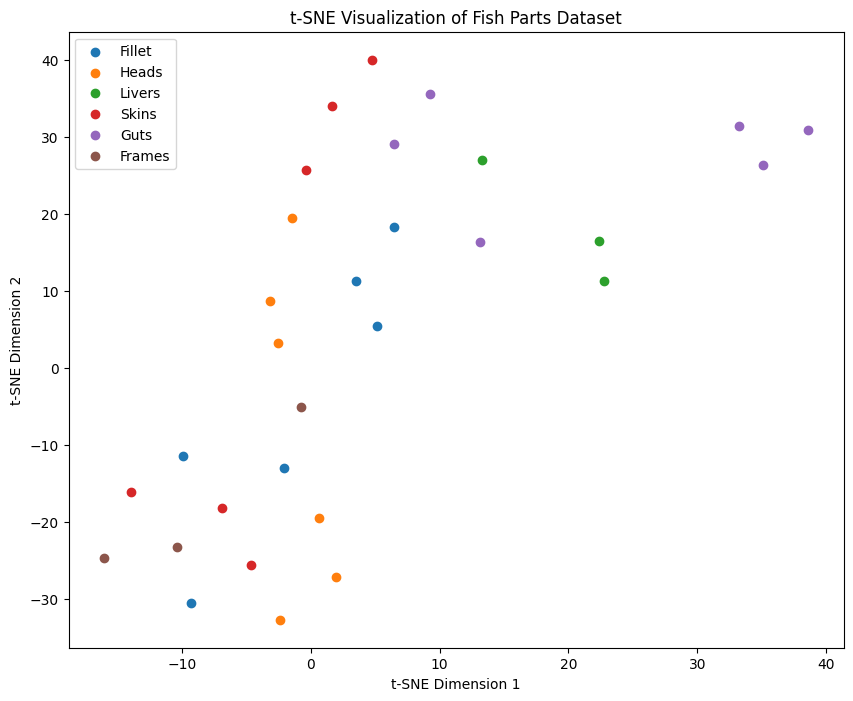

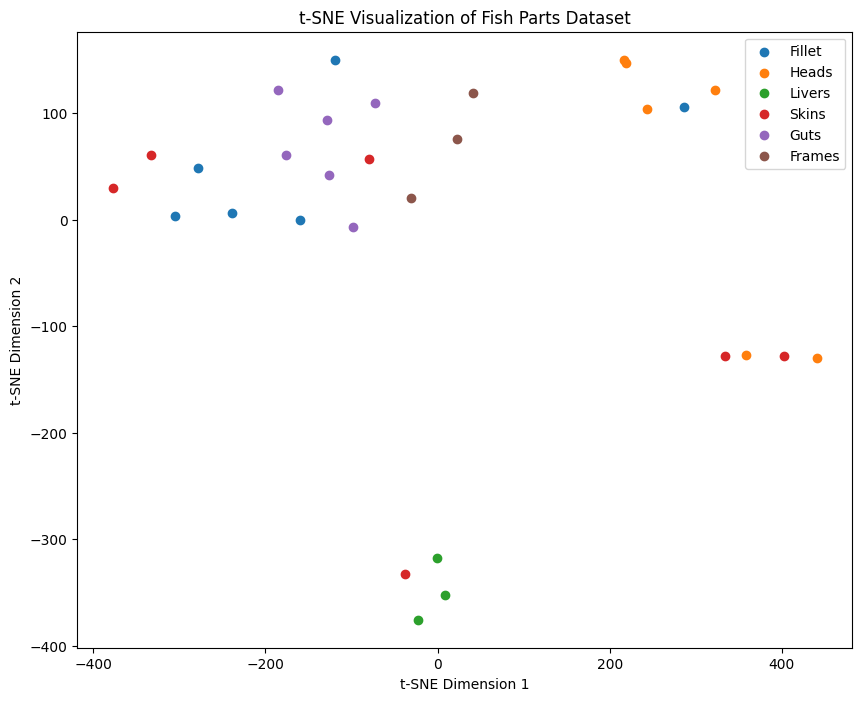

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.manifold import TSNE

# Perform t-SNE dimensionality reduction
perplexity = 10
features = toolbox.compile(expr=hof[0], pset=pset)
evaluate_classification(hof.items[0], verbose=True)

for X_set in [X, features]:
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    X_tsne = tsne.fit_transform(X_set)

    # Plot the data
    plt.figure(figsize=(10, 8))

    labels = ['Fillet','Heads','Livers','Skins','Guts','Frames']

    # Plot points belonging to different classes with different colors
    for idx, label in enumerate(np.unique(y)):
        plt.scatter(X_tsne[y == label, 0], X_tsne[y == label, 1], label=labels[idx])

    plt.title('t-SNE Visualization of Fish Parts Dataset')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend()
    plt.show()

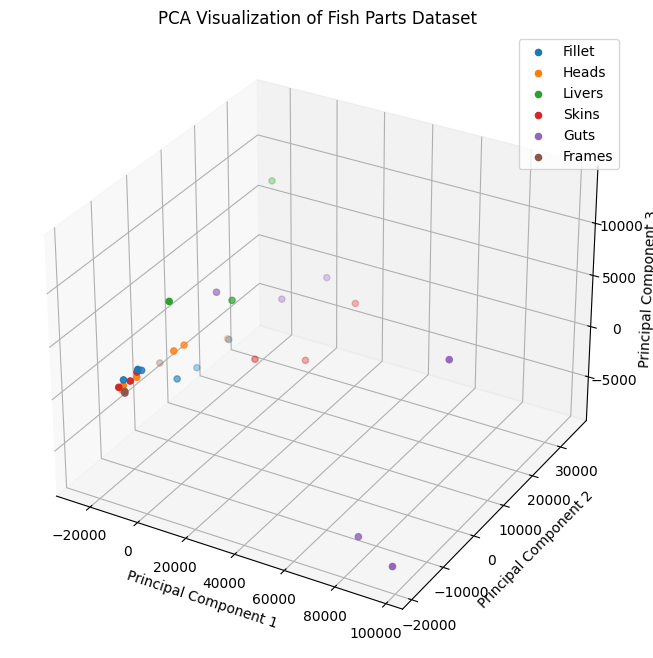

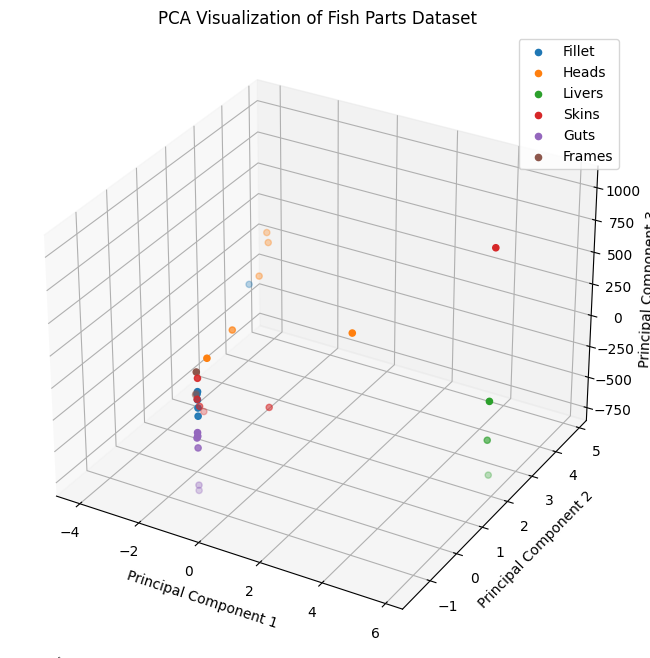

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Assuming you have your own dataset with features X and labels y
# Replace X and y with your actual data
# X should be your feature matrix and y should be your labels

for X_set in [X, features]:
    # Perform PCA dimensionality reduction
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X_set)

    # Plot the data
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    labels = ['Fillet','Heads','Livers','Skins','Guts','Frames']

    # Plot points belonging to different classes with different colors
    for idx, label in enumerate(np.unique(y)):
        ax.scatter(X_pca[y == label, 0], X_pca[y == label, 1], X_pca[y == label, 2], label=labels[idx])

    ax.set_title('PCA Visualization of Fish Parts Dataset')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.legend()
    plt.show()

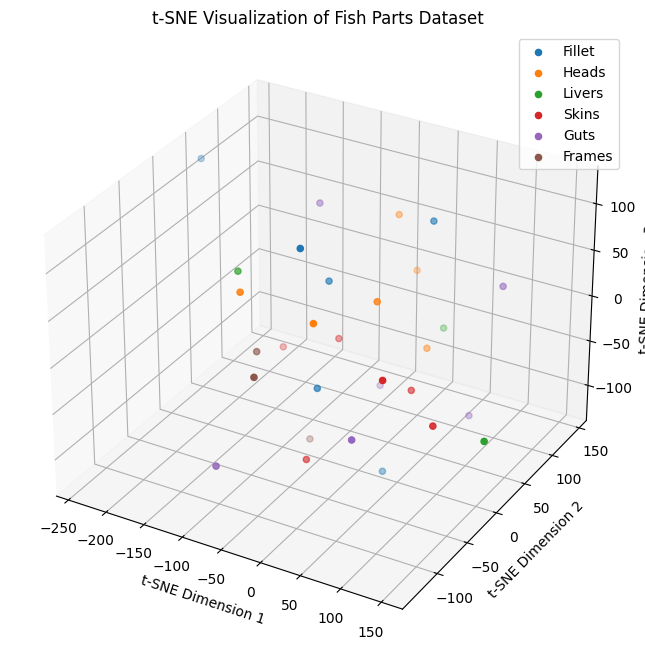

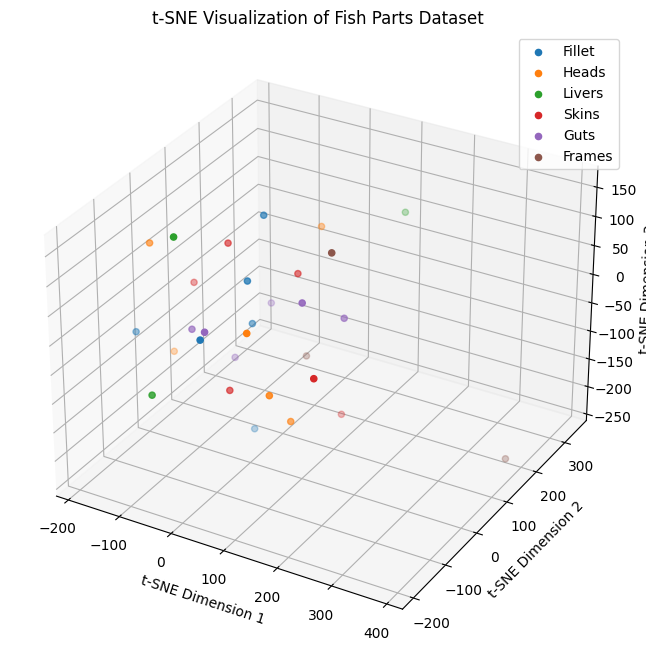

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

# Assuming you have your own dataset with features X and labels y
# Replace X and y with your actual data
# X should be your feature matrix and y should be your labels

for X_set in [X, features]:

    # Perform t-SNE dimensionality reduction
    tsne = TSNE(n_components=3, perplexity=10, random_state=42)
    X_tsne = tsne.fit_transform(X_set)

    # Plot the data
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    labels = ['Fillet','Heads','Livers','Skins','Guts','Frames']

    # Plot points belonging to different classes with different colors
    for idx, label in enumerate(np.unique(y)):
        ax.scatter(X_tsne[y == label, 0], X_tsne[y == label, 1], X_tsne[y == label, 2], label=labels[idx])

    ax.set_title('t-SNE Visualization of Fish Parts Dataset')
    ax.set_xlabel('t-SNE Dimension 1')
    ax.set_ylabel('t-SNE Dimension 2')
    ax.set_zlabel('t-SNE Dimension 3')
    ax.legend()
    plt.show()

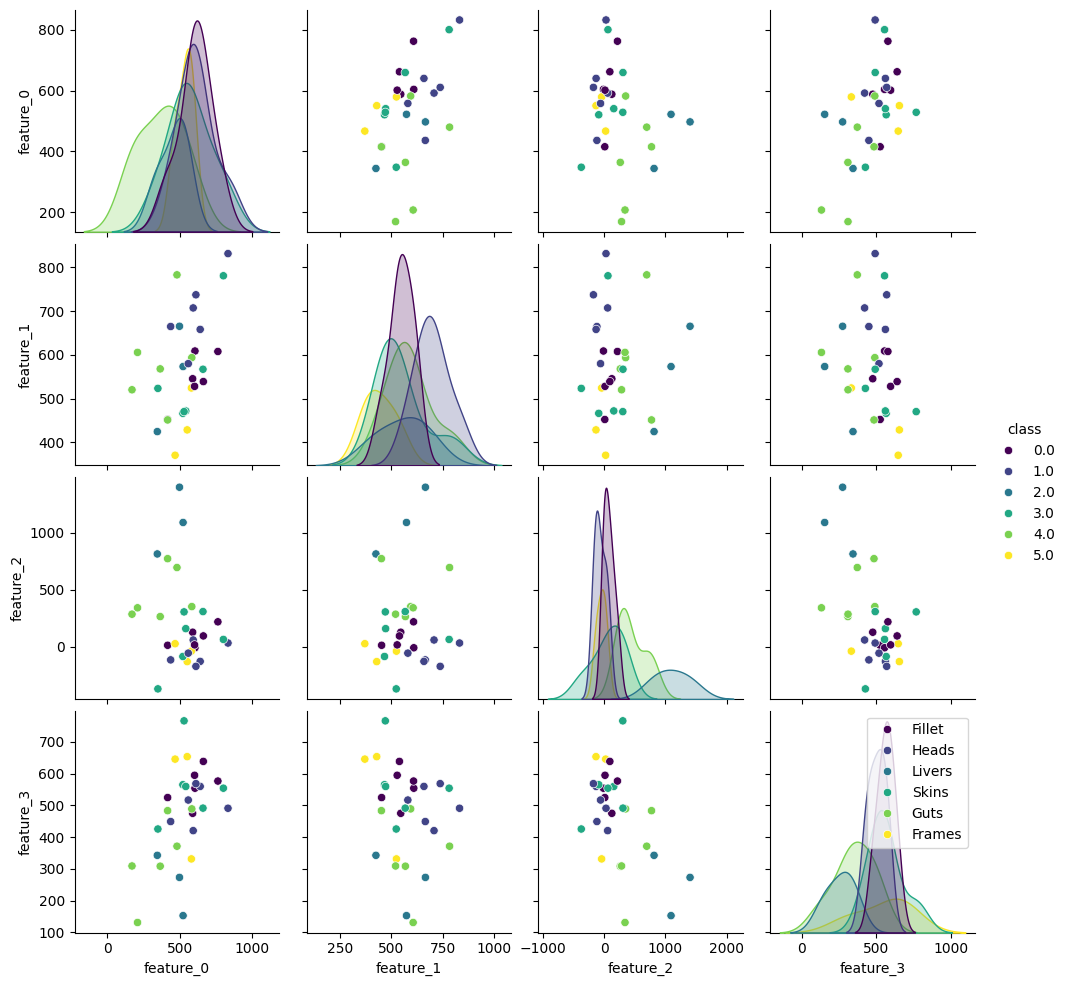

In [32]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

feature_no = 4
data = pd.DataFrame(features[:30,:feature_no], columns=[f'feature_{i}' for i in range(feature_no)])
data['class'] = y[:30]

# Add class labels to the DataFrame
labels = ['Fillet','Heads','Livers','Skins','Guts','Frames']

# Create pairplot
plot = sns.pairplot(data, hue='class', palette='viridis')

# Modify legend
handles = plot._legend_data.values()
plt.legend(handles, labels)
plt.show()

In [36]:
# Extract the fitness value from the training output.
! cat results.txt | awk '{ print $5 }' | sed 's/$/,/'

0.4288,
0.431024,
0.528555,
0.557951,
0.557951,
0.568289,
0.598075,
0.598183,
0.617565,
0.618576,
0.642668,
0.643339,
0.643536,
0.664008,
0.664008,
0.664034,
0.664161,
0.664161,
0.664161,
0.664161,
0.664161,
0.664161,
0.664161,
0.665444,
0.665444,
0.665444,
0.665444,
0.665444,
0.66576,
0.69504,
0.695153,
0.695153,
0.695492,
0.696114,
0.696176,
0.739485,
0.739485,
0.739486,
0.739486,
0.740636,
0.741731,
0.741731,
0.750597,
0.750597,
0.750597,
0.752842,
0.752842,
0.752842,
0.752901,
0.753308,
0.760042,
0.772325,
0.772325,
0.772325,
0.772999,
0.780042,
0.780093,
0.780625,
0.780808,
0.780838,
0.782095,
0.782657,
0.782683,
0.782683,
0.782683,
0.783132,
0.783132,
0.783132,
0.78373,
0.802683,
0.802683,
0.802683,
0.802705,
0.803001,
0.803001,
0.803027,
0.803378,
0.80373,
0.804264,
0.804264,
0.804264,
0.804589,
0.804589,
0.805056,
0.805056,
0.805056,
0.805056,
0.805056,
0.805056,
0.805056,
0.805749,
0.805749,
0.805749,
0.805749,
0.805749,
0.805749,
0.805749,
0.805749,
0.805749,
0.805749,
0.8057

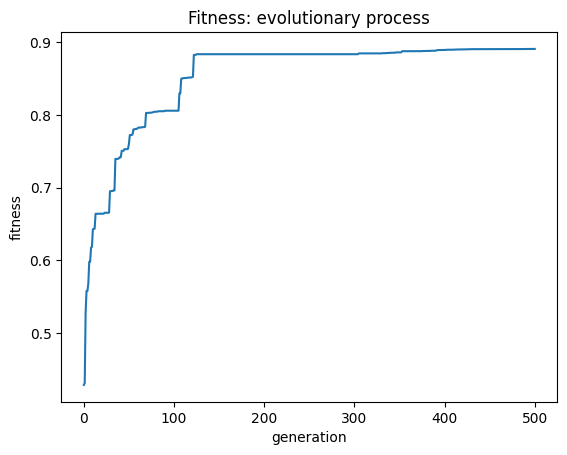

In [37]:
fitness = [
 0.4288,
0.431024,
0.528555,
0.557951,
0.557951,
0.568289,
0.598075,
0.598183,
0.617565,
0.618576,
0.642668,
0.643339,
0.643536,
0.664008,
0.664008,
0.664034,
0.664161,
0.664161,
0.664161,
0.664161,
0.664161,
0.664161,
0.664161,
0.665444,
0.665444,
0.665444,
0.665444,
0.665444,
0.66576,
0.69504,
0.695153,
0.695153,
0.695492,
0.696114,
0.696176,
0.739485,
0.739485,
0.739486,
0.739486,
0.740636,
0.741731,
0.741731,
0.750597,
0.750597,
0.750597,
0.752842,
0.752842,
0.752842,
0.752901,
0.753308,
0.760042,
0.772325,
0.772325,
0.772325,
0.772999,
0.780042,
0.780093,
0.780625,
0.780808,
0.780838,
0.782095,
0.782657,
0.782683,
0.782683,
0.782683,
0.783132,
0.783132,
0.783132,
0.78373,
0.802683,
0.802683,
0.802683,
0.802705,
0.803001,
0.803001,
0.803027,
0.803378,
0.80373,
0.804264,
0.804264,
0.804264,
0.804589,
0.804589,
0.805056,
0.805056,
0.805056,
0.805056,
0.805056,
0.805056,
0.805056,
0.805749,
0.805749,
0.805749,
0.805749,
0.805749,
0.805749,
0.805749,
0.805749,
0.805749,
0.805749,
0.805749,
0.805749,
0.805749,
0.805749,
0.805749,
0.805749,
0.829625,
0.829625,
0.849625,
0.850286,
0.850286,
0.850657,
0.850763,
0.850763,
0.850763,
0.851018,
0.851354,
0.851354,
0.851354,
0.851354,
0.851849,
0.852319,
0.882465,
0.882465,
0.882465,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.88343,
0.884537,
0.884537,
0.884537,
0.884537,
0.884537,
0.884537,
0.884537,
0.884537,
0.884537,
0.884537,
0.884537,
0.884537,
0.884537,
0.884537,
0.884537,
0.884537,
0.884537,
0.884537,
0.884537,
0.884537,
0.884537,
0.884538,
0.884538,
0.884538,
0.884538,
0.884541,
0.88478,
0.88478,
0.88478,
0.88478,
0.884884,
0.885077,
0.885077,
0.88516,
0.88516,
0.885427,
0.885427,
0.885427,
0.885427,
0.885427,
0.885431,
0.885908,
0.885908,
0.885908,
0.885908,
0.885908,
0.885955,
0.885955,
0.887531,
0.887531,
0.887531,
0.887531,
0.887531,
0.887538,
0.887538,
0.887538,
0.887538,
0.887538,
0.887611,
0.887611,
0.887611,
0.887611,
0.887611,
0.887611,
0.887611,
0.887612,
0.887612,
0.887612,
0.887618,
0.887618,
0.887619,
0.887824,
0.887824,
0.887831,
0.887831,
0.887954,
0.887954,
0.887954,
0.887954,
0.887954,
0.888175,
0.888175,
0.888175,
0.888175,
0.888175,
0.888175,
0.888807,
0.888807,
0.889165,
0.889165,
0.889165,
0.889233,
0.889233,
0.889237,
0.889237,
0.889237,
0.88926,
0.889519,
0.889519,
0.889519,
0.889519,
0.889621,
0.889621,
0.889629,
0.889629,
0.889703,
0.889703,
0.889703,
0.889921,
0.889921,
0.889921,
0.889921,
0.889921,
0.890035,
0.890035,
0.890035,
0.890091,
0.890091,
0.890091,
0.890091,
0.890192,
0.890192,
0.890251,
0.890251,
0.890343,
0.890343,
0.890343,
0.890343,
0.890343,
0.890359,
0.890359,
0.890372,
0.890372,
0.890382,
0.890395,
0.890395,
0.890395,
0.890395,
0.890395,
0.890395,
0.890395,
0.890395,
0.890395,
0.890395,
0.890401,
0.890401,
0.890401,
0.890401,
0.890401,
0.890405,
0.890407,
0.890428,
0.890428,
0.890428,
0.890428,
0.890433,
0.890433,
0.89045,
0.89045,
0.89045,
0.89045,
0.89045,
0.89045,
0.89045,
0.89045,
0.890456,
0.890456,
0.890493,
0.890493,
0.890493,
0.890493,
0.890493,
0.890493,
0.890493,
0.890495,
0.890495,
0.890525,
0.890525,
0.890525,
0.890525,
0.890525,
0.890525,
0.890525,
0.890527,
0.890545,
0.890545,
0.890545,
0.890545,
0.890545,
0.890654,
0.890654,
0.890654,
0.890654,
0.890687,
0.890687,
0.890687,]

plt.plot(fitness)
plt.title("Fitness: evolutionary process")
plt.xlabel("generation")
plt.ylabel("fitness")
plt.show()

## Visualization

In [35]:
from deap import base, creator, gp
import pygraphviz as pgv

multi_tree = hof[0]
for t_idx,tree in enumerate(multi_tree):
    nodes, edges, labels = gp.graph(tree)

    g = pgv.AGraph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    g.layout(prog="dot")

    for i in nodes:
        n = g.get_node(i)
        n.attr["label"] = labels[i]

    g.draw(f"tree-{t_idx}.pdf")

## Changelog

| Date | Title | Description | Update |
| --- | --- | --- | ---- |
| 2024-04-11 17:35 | Embedded class-dependent GP | Changed from a wrapper-based multi-tree GP to an embedded class dependent multi-tree GP |
| 2024-03-28 17:22 | KNN + cross validation | Changed the wrapper-based classifier to be KNN <br> Implemented cross validation due to low sample volume | |
| 2024-03-06 15:25 | SVM random state | Set the random state for the SVM to a fixed value | |
| 2024-02-27 16:31 | Fix fitness | Fixed fitness function to penalize intra-class distance <br> and reward inter-class distance. |
| 2024-02-26 15:59 | Intra/inter | Updated fitness value to include a normalized sum of <br> intraclass and interclass distance |
| 2024-02-14 16:56 | Mass spectra | Applications for MT-GP for rapid mass spectrometry dataset. | |
| 2022-08-21 17:30 | Multi-Objective - Onehot Encoding | Change to multi-objective problem, one-vs-all with a tree classifier for each class.<br> Y labels are encoded in onehot encodings, error is absolute difference between $|\hat{y} - y|$|
| 2022-08-22 20:44 | Non-linearity |  Introduce $ round . sigmoid $ to evaluate_classification() method.<br>Previously, we push each tree to predict either a 0 or 1 value with the onehot encoding representation.<br>Now, the non-linearity will map any negative value to a negative class 0, and any positive value to positive class 1.|
| 2022-08-22 21:06 | ~~Genetic operators for tree with worst fitness~~ | Only apply the genetic operators, crossover and mutation, to the tree with the worst fitness.<br> This guarantees monotonic improvement for the Multi-tree between generations, the best performing tree remain unaltered.| (Update) This was very slow, and inefficient,<br> basically turned the GP into a single objective,<br>that balances multi-objective fitness functions. |
| 2022-08-22 21:15 | Halloffame Equality Operator | Numpy equality function (operators.eq) between two arrays returns the equality element wise,<br>which raises an exception in the if similar() check of the hall of fame. <br> Using a different equality function like numpy.array_equal or numpy.allclose solve this issue.|
| 2022-08-22 23:22 | Elitism as aggregate best tree | Perform elitsim by constructing the best tree, as the tree with best fitness from each clas.<br>The goal is to have monotonous improvement across the multiple objective functions.|
| 2022-08-22 23:32 | Update fitness for elite | The elitism was not working as intended, as the multi-objectives didn't appear to increase monotnously.<br> This was because the aggregate fitness was not being assigned to the best individual after it was created.<br>Therefore the best invidiual was not passed on to the next generation. |
| 2022-08-22 02:28 | staticLimit max height | Rewrite the gp.staticLimit decorator function to handle the Multi-tree representation.<br>Note: size and depth are different values!<br>depth is the maximum length of a root-to-leaf traversal,<br>size is the total number of nodes.|
| 2022-08-24 9:37 | Evaluate Mutli-tree train accuracy | Take the classification accuracy as the argmax for the aggregate multitree.<br> 74% training accuracy, which is not ideal, but this shall improve with time.|
| 2022-08-25 13:30 | Single-objective fitness | Change the fitness function to a single objective fitness function.<br>This forces the multi-tree GP to find the best tree subset for one-vs-rest classification performance.|
| 2022-08-25 20:01 | Fitness = Balanced accuracy + distance measure | Implement the fitness function for MCIFC, but for multi-class classification from (Tran 2019) |
| 2022-08-26 21:27 | Sklearn Balanced Accuracy | Changed to the balanced accuracy metric from sklearn.<br>This is much easier to use for now, probably faster than the previous method as well. |
| 2022-09-05 17:00 | Reject invalid predictions | Change the fitness function to reject invalid predictioctions outright -<br>e.g. multi-label or zero-label predictions<br>- when computing the balanced accuracy for the fitness function. |
| 2022-09-13 19:00 | Mutation + Crossover = 100% | Ensure the mutation and crossover rate sum to 100%,<br>not necessary with deap, but good to avoid conference questions |
| 2022-09-13 21:00 | Feature Construction | Changed to Wrapper-based Feature Construction with Multi-tree GP.|
| 2022-09-13 21:34 | $m = r \times c$ | Add more trees, following example from (Tran 2019).<br> With 8 trees for a multi-class classification<br> $m = r \times c = 8$ trees, where number of classes $c = 4$, and reconstruction ratio $r = 2$/ |
| 2022-09-30 19:49 | Quick Evalaute | Manually parse the GP trees, 5x speedup for DEAP in Python (Zhang 2022). |
| 2022-10-13 6:02 | Ignore timestamps after 4500 | Ignore timestamps after 4500 did not improve accuracy for SVM classifier.<br>So the bizzare pattern that occurs on GC-MS image there has important information.<br> Should investigate this further, perhaps ask Daniel as he is a domain expert.|
| 2022-10-13 22:16 | Cross validation | Evaluate the mean balanced classification accuracy over stratified k-fold cross validation.|
| 2023-01-13 20:58 | 2x speedup | Only evaluate test set for verbose alternative of the evaluate_classification method.<br> This results in a 2x speedup in the efficiency of the training regime.|